Mounted at /content/drive/
/content/drive/My Drive/Project FPAR2/ego-rnn
importing Jupyter notebook from spatial_transforms.ipynb
importing Jupyter notebook from twoStreamModel.ipynb
importing Jupyter notebook from flow_resnet.ipynb
importing Jupyter notebook from objectAttentionModelConvLSTM.ipynb
importing Jupyter notebook from resnetMod.ipynb
importing Jupyter notebook from MyConvLSTMCell.ipynb
importing Jupyter notebook from makeDatasetTwoStream.ipynb
importing Jupyter notebook from plotting.ipynb


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


MyConvLSTMCell.ipynb:31: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
MyConvLSTMCell.ipynb:32: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
MyConvLSTMCell.ipynb:33: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
MyConvLSTMCell.ipynb:35: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
MyConvLSTMCell.ipynb:36: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
MyConvLSTMCell.ipynb:37: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
MyConvLSTMCell.ipynb:39: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
MyConvLSTMCell.ipynb:40: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
MyConvLSTMCell.ipynb:41: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
MyCo

Average training loss after 1 epoch = 3.7308614253997803 
Training accuracy after 1 epoch = 12.609970674486803% 
Val Loss after 1 epochs, loss = 2.638587474822998
Val Accuracy after 1 epochs = 32.758620689655174%
Average training loss after 2 epoch = 2.373663902282715 
Training accuracy after 2 epoch = 39.002932551319645% 
Val Loss after 2 epochs, loss = 2.339586019515991
Val Accuracy after 2 epochs = 44.827586206896555%
Average training loss after 3 epoch = 1.8416080474853516 
Training accuracy after 3 epoch = 50.146627565982406% 
Val Loss after 3 epochs, loss = 1.7271697521209717
Val Accuracy after 3 epochs = 55.172413793103445%
Average training loss after 4 epoch = 1.5075411796569824 
Training accuracy after 4 epoch = 56.89149560117303% 
Val Loss after 4 epochs, loss = 2.3269708156585693
Val Accuracy after 4 epochs = 41.37931034482759%
Average training loss after 5 epoch = 1.3700652122497559 
Training accuracy after 5 epoch = 62.17008797653959% 
Val Loss after 5 epochs, loss = 1.836

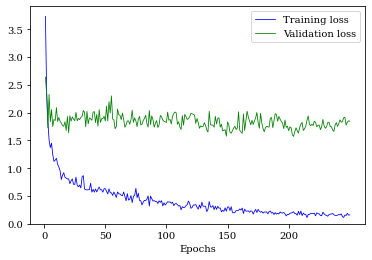

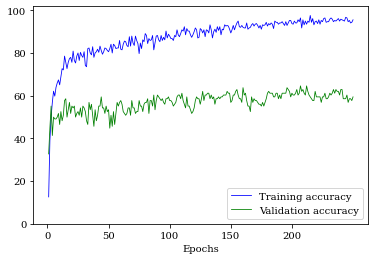

In [1]:
!pip install import_ipynb
import import_ipynb

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd '/content/drive/My Drive/Project FPAR2/ego-rnn/'

from __future__ import print_function, division
from spatial_transforms import (Compose, ToTensor, CenterCrop, Scale, Normalize, MultiScaleCornerCrop,
                                RandomHorizontalFlip)
!pip install tensorboardX
from tensorboardX import SummaryWriter
import torch.nn as nn
from twoStreamModel import *
from torch.autograd import Variable
from torch.utils.data.sampler import WeightedRandomSampler
from makeDatasetTwoStream import *
import argparse
import sys
from plotting import *

def main_run(dataset, flowModel, rgbModel, stackSize, seqLen, memSize, trainDatasetDir, valDatasetDir, outDir,
             trainBatchSize, valBatchSize, lr1, numEpochs, decay_step, decay_factor):


    if dataset == 'gtea61':
        num_classes = 61
    elif dataset == 'gtea71':
        num_classes = 71
    elif dataset == 'gtea_gaze':
        num_classes = 44
    elif dataset == 'egtea':
        num_classes = 106
    else:
        print('Dataset not found')
        sys.exit()

    model_folder = outDir  # Dir for saving models and log files
    # Create the dir

    # Log files
    writer = SummaryWriter(model_folder)
    train_log_loss = open((model_folder + '/train_log_loss.txt'), 'w')
    train_log_acc = open((model_folder + '/train_log_acc.txt'), 'w')
    val_log_loss = open((model_folder + '/val_log_loss.txt'), 'w')
    val_log_acc = open((model_folder + '/val_log_acc.txt'), 'w')


    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    normalize = Normalize(mean=mean, std=std)

    spatial_transform = Compose([Scale(256), RandomHorizontalFlip(), MultiScaleCornerCrop([1, 0.875, 0.75, 0.65625], 224),
                                 ToTensor(), normalize])

    vid_seq_train = makeDataset(trainDatasetDir,spatial_transform=spatial_transform,
                               sequence=False, numSeg=1, stackSize=stackSize, fmt='.png', seqLen=seqLen)

    train_loader = torch.utils.data.DataLoader(vid_seq_train, batch_size=trainBatchSize,
                            shuffle=True, num_workers=4, pin_memory=True)

    if valDatasetDir is not None:

        vid_seq_val = makeDataset(valDatasetDir,
                                   spatial_transform=Compose([Scale(256), CenterCrop(224), ToTensor(), normalize]),
                                   sequence=False, train=False, numSeg=1, stackSize=stackSize, fmt='.png', phase='Test',
                                   seqLen=seqLen)

        val_loader = torch.utils.data.DataLoader(vid_seq_val, batch_size=valBatchSize,
                                shuffle=False, num_workers=2, pin_memory=True)
        valSamples = vid_seq_val.__len__()

    model = twoStreamAttentionModel(flowModel=flowModel, frameModel=rgbModel, stackSize=stackSize, memSize=memSize,
                                    num_classes=num_classes)

    for params in model.parameters():
        params.requires_grad = False

    model.train(False)
    train_params = []

    for params in model.classifier.parameters():
        params.requires_grad = True
        train_params += [params]

    for params in model.frameModel.lstm_cell.parameters():
        train_params += [params]
        params.requires_grad = True

    for params in model.frameModel.resNet.layer4[0].conv1.parameters():
        params.requires_grad = True
        train_params += [params]

    for params in model.frameModel.resNet.layer4[0].conv2.parameters():
        params.requires_grad = True
        train_params += [params]

    for params in model.frameModel.resNet.layer4[1].conv1.parameters():
        params.requires_grad = True
        train_params += [params]

    for params in model.frameModel.resNet.layer4[1].conv2.parameters():
        params.requires_grad = True
        train_params += [params]

    for params in model.frameModel.resNet.layer4[2].conv1.parameters():
        params.requires_grad = True
        train_params += [params]
    #
    for params in model.frameModel.resNet.layer4[2].conv2.parameters():
        params.requires_grad = True
        train_params += [params]
    #
    for params in model.frameModel.resNet.fc.parameters():
        params.requires_grad = True
        train_params += [params]

    base_params = []
    for params in model.flowModel.layer4.parameters():
        base_params += [params]
        params.requires_grad = True

    model.cuda()

    trainSamples = vid_seq_train.__len__()
    min_accuracy = 0

    loss_fn = nn.CrossEntropyLoss()
    optimizer_fn = torch.optim.SGD([
        {'params': train_params},
        {'params': base_params, 'lr': 1e-4},
    ], lr=lr1, momentum=0.9, weight_decay=5e-4)

    optim_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_fn, step_size=decay_step, gamma=decay_factor)
    train_iter = 0
    loss_train_list=[]
    loss_val_list=[]
    acc_train_list=[]
    acc_val_list=[]

    for epoch in range(numEpochs):
        optim_scheduler.step()
        epoch_loss = 0
        numCorrTrain = 0
        iterPerEpoch = 0
        model.classifier.train(True)
        model.flowModel.layer4.train(True)
        for j, (inputFlow, inputFrame, targets) in enumerate(train_loader):
            train_iter += 1
            iterPerEpoch += 1
            optimizer_fn.zero_grad()
            inputVariableFlow = Variable(inputFlow.cuda())
            inputVariableFrame = Variable(inputFrame.permute(1, 0, 2, 3, 4).cuda())
            labelVariable = Variable(targets.cuda())
            output_label = model(inputVariableFlow, inputVariableFrame)
            loss = loss_fn(F.log_softmax(output_label, dim=1), labelVariable)
            loss.backward()
            optimizer_fn.step()
            _, predicted = torch.max(output_label.data, 1)
            numCorrTrain += (predicted == targets.cuda()).sum().item()
            epoch_loss += loss.data
        avg_loss = epoch_loss / iterPerEpoch
        trainAccuracy = (numCorrTrain / trainSamples) * 100
        loss_train_list.append(avg_loss)
        acc_train_list.append(trainAccuracy)
        print('Average training loss after {} epoch = {} '.format(epoch + 1, avg_loss))
        print('Training accuracy after {} epoch = {}% '.format(epoch + 1, trainAccuracy))
        writer.add_scalar('train/epoch_loss', avg_loss, epoch + 1)
        writer.add_scalar('train/accuracy', trainAccuracy, epoch + 1)
        train_log_loss.write('Training loss after {} epoch = {}\n'.format(epoch + 1, avg_loss))
        train_log_acc.write('Training accuracy after {} epoch = {}\n'.format(epoch + 1, trainAccuracy))
        if valDatasetDir is not None:
            if (epoch + 1) % 1 == 0:
                model.train(False)
                val_loss_epoch = 0
                val_iter = 0
                numCorr = 0
                for j, (inputFlow, inputFrame, targets) in enumerate(val_loader):
                    val_iter += 1
                    inputVariableFlow = Variable(inputFlow.cuda())
                    inputVariableFrame = Variable(inputFrame.permute(1, 0, 2, 3, 4).cuda())
                    labelVariable = Variable(targets.cuda())
                    output_label = model(inputVariableFlow, inputVariableFrame)
                    loss = loss_fn(F.log_softmax(output_label, dim=1), labelVariable)
                    val_loss_epoch += loss.data
                    _, predicted = torch.max(output_label.data, 1)
                    numCorr += (predicted == labelVariable.data).sum().item()
                val_accuracy = (numCorr / valSamples) * 100
                avg_val_loss = val_loss_epoch / val_iter
                loss_val_list.append(avg_val_loss)
                acc_val_list.append(val_accuracy)
                print('Val Loss after {} epochs, loss = {}'.format(epoch + 1, avg_val_loss))
                print('Val Accuracy after {} epochs = {}%'.format(epoch + 1, val_accuracy))
                writer.add_scalar('val/epoch_loss', avg_val_loss, epoch + 1)
                writer.add_scalar('val/accuracy', val_accuracy, epoch + 1)
                val_log_loss.write('Val Loss after {} epochs = {}\n'.format(epoch + 1, avg_val_loss))
                val_log_acc.write('Val Accuracy after {} epochs = {}%\n'.format(epoch + 1, val_accuracy))
                if val_accuracy > min_accuracy:
                    save_path_model = (model_folder + '/model_twoStream_state_dict.pth')
                    torch.save(model.state_dict(), save_path_model)
                    min_accuracy = val_accuracy
        else:
            if (epoch + 1) % 10 == 0:
                save_path_model = (model_folder + '/model_twoStream_state_dict_epoch' + str(epoch + 1) + '.pth')
                torch.save(model.state_dict(), save_path_model)
    train_log_loss.close()
    train_log_acc.close()
    val_log_acc.close()
    val_log_loss.close()
    writer.export_scalars_to_json(model_folder + "/all_scalars.json")
    writer.close()
    plotting(loss_train_list, loss_val_list,acc_train_list, acc_val_list)


def __main__():

    flow='./experiments/flow/model_flow_state_dict.pth'
    rgb='/content/drive/My Drive/Project FPAR2/ego-rnn/experiments/rgb/stage2/cam/model_rgb_state_dict.pth'

    main_run(dataset='gtea61', flowModel=flow, rgbModel=rgb, stackSize=5, seqLen=7, memSize=512, trainDatasetDir='./GTEA61', valDatasetDir='./GTEA61', outDir='./experiments/twostream/7',
             trainBatchSize=32, valBatchSize=64, lr1=1e-2, numEpochs=250, decay_step=1, decay_factor=0.99)

__main__()

In [ ]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-65eacb67-6a52-7ee7-c514-dc27371161b7)
